In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from quivr.utils import rewrite_program_postgres, str_to_program_postgres
import seaborn as sns
import pandas as pd 
from scipy import stats

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

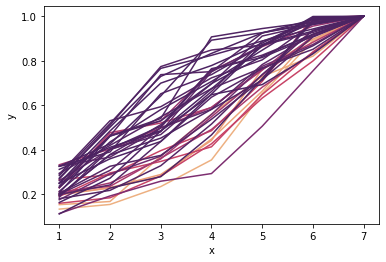

In [78]:
def best_score_per_iteration_aggregate():
    exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/synthetic_scene_graph_without_duration-npred_5-nattr_pred_2-40_ancestors"
    test_f1_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/synthetic_scene_graph_without_duration-npred_5-nattr_pred_2-40/stats/vocal_postgres-topk"
    median_f1_list = []
    best_score_per_iteration_list = []
    for filename in os.listdir(exp_dir):
        query_str = filename[:-4]
        with open(os.path.join(exp_dir, filename), "r") as f:
            lines = f.readlines()
            lines = [line.rstrip() for line in lines]
        current_iteration = int(lines[0]) + 1
        best_score_per_iteration = np.zeros(int(lines[0]))
        for i, line in enumerate(lines):
            if i % 3 == 0: 
                if current_iteration > int(line):
                    current_iteration = int(line)
                    best_score_per_iteration[current_iteration-1] = float(lines[i+2])
#         print(best_score_per_iteration)
        best_score_per_iteration_list.append(best_score_per_iteration)
        with open(os.path.join(test_f1_dir, query_str+".json"), "r") as f:
            jsn = json.load(f)
            f1_scores = np.array(jsn["score_median"])[:, -1]
            median_f1 = np.median(f1_scores)
            median_f1_list.append(median_f1)
            
    # Do the plot
    fig, ax = plt.subplots()
    data_x = []
    data_y = []
    data_c = []
    for median_f1, best_score_per_iteration in zip(median_f1_list, best_score_per_iteration_list):
        for i, best_score in enumerate(best_score_per_iteration, 1):
            data_x.append(i)
            data_y.append(best_score)
            data_c.append(median_f1) 
    data = pd.DataFrame(list(zip(data_x, data_y, data_c)), columns =['x', 'y', 'c'])
    lp = sns.lineplot(data=data, x="x", y="y", hue="c", palette="flare", hue_norm=matplotlib.colors.LogNorm())
#     fig.colorbar(lp)
best_score_per_iteration_aggregate()

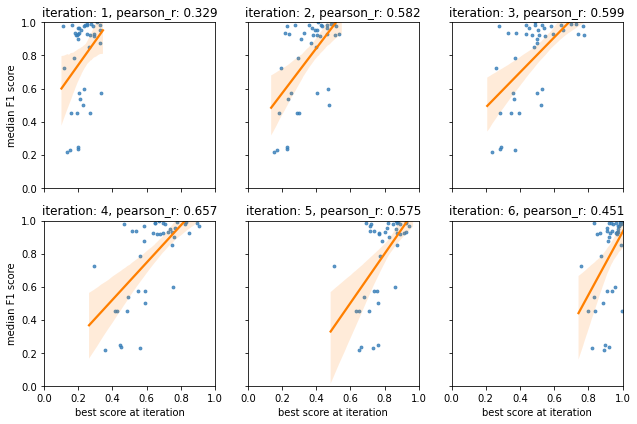

In [5]:
def best_score_per_iteration():
    exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/synthetic_scene_graph_without_duration-npred_5-nattr_pred_2-40_ancestors"
    test_f1_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/synthetic_scene_graph_without_duration-npred_5-nattr_pred_2-40/stats/vocal_postgres-topk"
    median_f1_list = []
    best_score_per_iteration_list = []
    for filename in os.listdir(exp_dir):
        query_str = filename[:-4]
        with open(os.path.join(exp_dir, filename), "r") as f:
            lines = f.readlines()
            lines = [line.rstrip() for line in lines]
        current_iteration = int(lines[0]) + 1
        best_score_per_iteration = np.zeros(int(lines[0]))
        for i, line in enumerate(lines):
            if i % 3 == 0: 
                if current_iteration > int(line):
                    current_iteration = int(line)
                    best_score_per_iteration[current_iteration-1] = float(lines[i+2])
#         print(best_score_per_iteration)
        best_score_per_iteration_list.append(best_score_per_iteration)
        with open(os.path.join(test_f1_dir, query_str+".json"), "r") as f:
            jsn = json.load(f)
            f1_scores = np.array(jsn["score_median"])[:, -1]
            median_f1 = np.median(f1_scores)
            median_f1_list.append(median_f1)
            
    # Do the plot
    best_score_per_iteration_list = np.array(best_score_per_iteration_list)[:, :-1]
#     fig, axs = plt.subplots(best_score_per_iteration_list.shape[1], figsize = (4, 28))
    fig, axs = plt.subplots(2, 3, figsize = (9, 6))
    for i in range(best_score_per_iteration_list.shape[1]):
        best_score_per_iteration = best_score_per_iteration_list[:, i]
        x = []
        y = []
        for median_f1, best_score in zip(median_f1_list, best_score_per_iteration):
            x.append(best_score)
            y.append(median_f1)
        x = np.array(x)
        y = np.array(y)
        sns.regplot(x=x, y=y, ax=axs[i//3, i%3], truncate=False, scatter_kws={'color': CB_color_cycle[0], 's':8}, line_kws = {'color': CB_color_cycle[1]})
        pearson_r = stats.pearsonr(x, y)[0]
        
        axs[i//3, i%3].set_xlim(left=0, right=1)
        axs[i//3, i%3].set_ylim(bottom=0, top=1)
        axs[i//3, i%3].set(xlabel="best score at iteration", ylabel="median F1 score")
        axs[i//3, i%3].set_title("iteration: {}, pearson_r: {}".format(i+1, np.round(pearson_r, 3), fontsize=10))
    for ax in axs.flat:
        ax.label_outer()
    fig.tight_layout()
    
best_score_per_iteration()